# Exercise 10 - Shape optimization

In [1]:
from math import sqrt
import matplotlib.pyplot as plt
import torch
from simple_fem import FEM, Quad, import_mesh

torch.set_default_dtype(torch.double)

## Task 1 - Analysis of stress in a fillet

We import the mesh from a file named "mesh/fillet.vtu" using the function `import_mesh(filename, E, nu)`. The mesh file should be placed in a subdirectory `mesh` in the same directory as this notebook. It contains a fillet geometry meshed with quadrilateral elements. It is assigned symmetry boundary conditions at the left and bottom boundary as well as load at the right boundary.

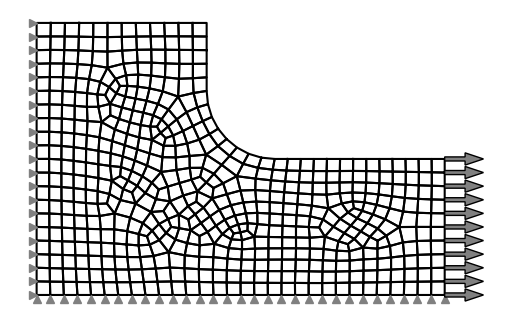

In [2]:
# Import mesh
fillet = import_mesh("fillet.vtu", 100.0, 0.25)

# Constrain left boundary
left = fillet.nodes[:, 0] == 0.0
fillet.constraints[left, 0] = True

# Constrain bottom boundary
bottom = fillet.nodes[:, 1] == 0.0
fillet.constraints[bottom, 1] = True

# Force at right boundary
right = fillet.nodes[:, 0] == 60.0
fillet.forces[right, 0] = 1.0
fillet.forces[1, 0] = 0.5
fillet.forces[2, 0] = 0.5

# Plot the fillet
fillet.plot()

a) Solve the FEM problem and plot the displacement magnitude.

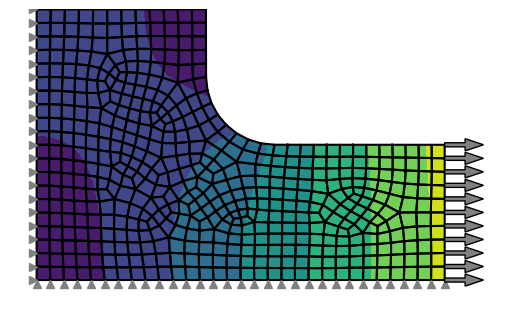

In [3]:
# Solve
u, f = fillet.solve()

# Plot
fillet.plot(u, node_property=torch.norm(u, dim=1))

b) You are given a function named `mises_stress(u)`. It takes a displacement solution `u` as argument and returns the v. Mises stress for all elements in the FEM model. 

Try to understand the code and write down what is happening in this code using the notation from the lecture.

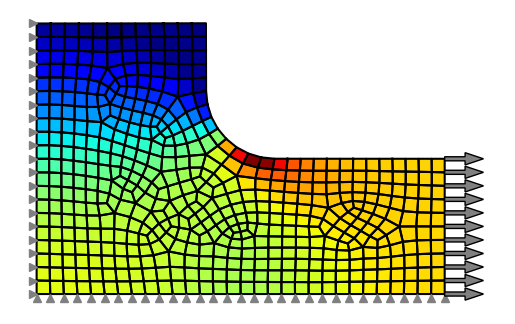

In [4]:
quad = Quad()


def mises_stress(u):
    mises = []
    for element in fillet.elements:
        # Extract node positions of element
        xe = fillet.nodes[element, :]

        # Extract displacement degrees of freedom
        ue = u[element, :].ravel()

        # Set position of evaluation
        xi = [0.0, 0.0]

        # Jacobian
        J = quad.B(xi) @ xe

        # Compute B
        B = torch.linalg.inv(J) @ quad.B(xi)
        zeros = torch.zeros(quad.nodes)

        # Compute D
        D0 = torch.stack([B[0, :], zeros], dim=-1).ravel()
        D1 = torch.stack([zeros, B[1, :]], dim=-1).ravel()
        D2 = torch.stack([B[1, :], B[0, :]], dim=-1).ravel()
        D = torch.stack([D0, D1, D2])

        # Compute stress
        s = fillet.C @ D @ ue
        mises.append(torch.sqrt(s[0] ** 2 + s[1] ** 2 - s[0] * s[1] + 3 * s[2] ** 2))
    return torch.stack(mises)


# Plot the results
stress = mises_stress(u)
fillet.plot(u, element_property=stress, cmap="jet")

c) Compute the maximum v. Mises stress in the component.

In [5]:
print(max(mises_stress(u)))

tensor(0.7269)


## Task 2 - Morph functions for the fillet
We want to optimize the fillet shape. To do so, we define shape modifications based on radial basis functions at four nodes at the fillet.

a) Precompute the values of a radial basis function 

$$\varphi(r) = \exp(-(\epsilon r)^2)$$

with $\epsilon=0.2$ for all nodes.

In [6]:
# Distances between all nodes - use torch.cdist()
r = torch.cdist(fillet.nodes, fillet.nodes)

# Set epsilon
epsilon = 0.2

# Compute phi
phi = torch.exp(-((epsilon * r) ** 2))

b) Plot the precomputed radial basis function associated with Node 3 as a node property on the mesh. How do you interpret this plot?

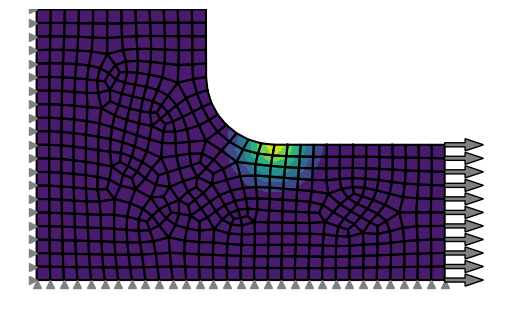

In [7]:
# Extract function values for RBF associated with Node 3
rbf_3 = phi[3, :]
fillet.plot(u, node_property=rbf_3)

c) Implement a function `morph(fem, nids, x, dir)` that adjusts the nodal positions of nodes with IDs `nids` in the `fem` model to the values `x` in direction `dir`.

In [8]:
def morph(fem, nids, x, dir):
    # Build matrix
    M = phi[:, nids]
    M = M[nids, :]

    # Solve linear equation system
    weights = torch.linalg.solve(M, x - fem.nodes[nids, dir])

    # Apply deformation
    for weight, node in zip(weights, nids):
        fem.nodes[:, dir] += weight * phi[node, :]

## Task 3 - Optimize the fillet shape
Now, we want to find the optimal position of four control points given by the IDs `3`, `5`, `7`, and `58` to minimize the maximum stress in the fillet. These nodes are located along the fillet radius:

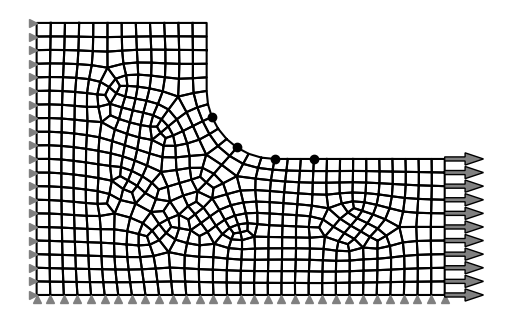

In [9]:
# Chosen control nodes
control_nodes = [3, 5, 7, 58]

# Plot the base mesh
fillet.plot()

# Plot control nodes
cx = fillet.nodes[control_nodes, 0]
cy = fillet.nodes[control_nodes, 1]
plt.scatter(cx, cy, marker="o", color="black")

You are provided with the following two functions from previous exercises for optimization.

In [10]:
def box_constrained_decent(func, x_init, x_lower, x_upper, eta=0.1, max_iter=100, tol=1E-10):
    x = x_init.clone().requires_grad_()
    for i in range(max_iter):
        x_old = x.clone()
        grad = torch.autograd.grad(func(x).sum(), x)[0]
        x = x - eta * grad
        x = torch.max(torch.min(x, x_upper), x_lower)
        if torch.norm(x-x_old) < tol:
            return x
    return x

def MMA(func, x_k, L_k, U_k):
    x_lin = x_k.clone().requires_grad_()
    grads = torch.autograd.grad(func(x_lin), x_lin)[0]
    neg_grad = grads < 0.0
    pos_grad = ~neg_grad
    f_k = func(x_k)

    def approximation(x):
        p = torch.zeros_like(grads)
        p[pos_grad] = (U_k[pos_grad] - x_k[pos_grad]) ** 2 * grads[pos_grad]
        q = torch.zeros_like(grads)
        q[neg_grad] = -((x_k[neg_grad] - L_k[neg_grad]) ** 2) * grads[neg_grad]
        return (
            f_k
            - torch.sum(p / (U_k - x_k) + q / (x_k - L_k))
            + torch.sum(p / (U_k - x) + q / (x - L_k))
        )

    return approximation

a) We need to define the objective function `f`. Given the positions of our control nodes `x`, compute the five largest v. Mises stresses in the fillet and return the sum of them as value of the objective function.

In [11]:
def f(x):
    # Update nodes
    morph(fillet, control_nodes, x, 1)
    # Solve fem with updated nodes
    u_k, f_k = fillet.solve()
    # Compute stress
    stress = mises_stress(u_k)
    # Return top 5 stresses
    top5 = torch.topk(stress, 5)[0]
    return top5.sum()

b) Why might it be better to return the sum of the top five stresses instead of just the maximum value? What alternatives can you think of?

c) The following function performs optimization of the objective function via MMA. Why are there no Lagrange multipliers?

In [12]:
def optimize(x_0, x_min, x_max, iter):
    s = 0.5

    # Set up lists for L, U, x
    L = []
    U = []
    x = [x_0]
    objective = [f(x_0)]

    for k in range(iter):
        # Update asymptotes with heuristic procedure (see Exercise 04)
        if k > 1:
            L_k = torch.zeros_like(L[k - 1])
            U_k = torch.zeros_like(U[k - 1])
            for j in range(len(L_k)):
                if (x[k][j] - x[k - 1][j]) * (x[k - 1][j] - x[k - 2][j]) < 0.0:
                    L_k[j] = x[k][j] - s * (x[k - 1][j] - L[k - 1][j])
                    U_k[j] = x[k][j] + s * (U[k - 1][j] - x[k - 1][j])
                else:
                    L_k[j] = x[k][j] - 1.0 / sqrt(s) * (x[k - 1][j] - L[k - 1][j])
                    U_k[j] = x[k][j] + 1.0 / sqrt(s) * (U[k - 1][j] - x[k - 1][j])
            L.append(L_k)
            U.append(U_k)
        else:
            L.append(x[k] - s * (x_max - x_min))
            U.append(x[k] + s * (x_max - x_min))

        # Compute lower move limit in this step
        x_min_k = torch.maximum(x_min, 0.9 * L[k] + 0.1 * x[k])
        x_max_k = torch.minimum(x_max, 0.9 * U[k] + 0.1 * x[k])

        # Compute the current approximation function and save gradients
        f_tilde = MMA(f, x[k], L[k], U[k])

        # Compute the maximum of the dual function
        x_star = box_constrained_decent(f_tilde, x_0, x_min_k, x_max_k, eta=10.0)

        # Compute current optimal point with dual solution
        x.append(x_star.detach())
        objective.append(f(x_star).detach())

    return x, objective

d) Set the initial design variables to the vertical position of the control nodes. Set `x_min` and `x_max` such that they can move up  and down by 1 and run the optimization for 30 iterations.

In [13]:
# Bounds on variables
x_0 = fillet.nodes[control_nodes, 1]
x_min = x_0 - 1.0
x_max = x_0 + 1.0

x_opt, f_opt = optimize(x_0, x_min, x_max, 30)

e) Plot the evolution of the objective value and the design variables vs. iteration count.

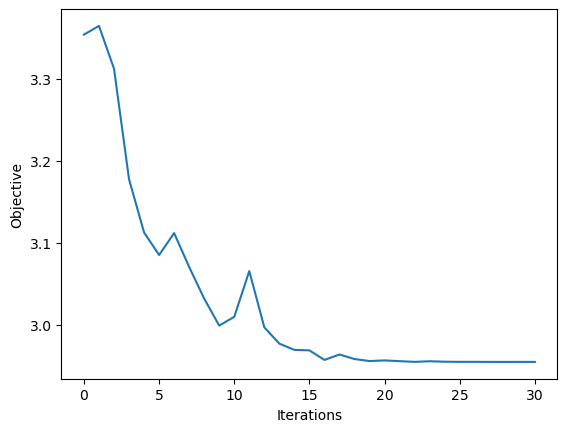

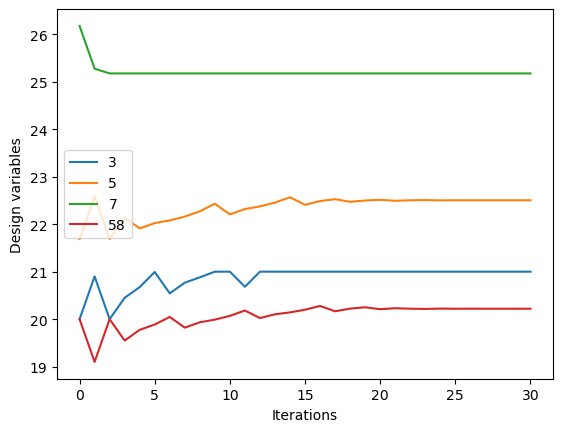

In [14]:
plt.plot(f_opt)
plt.xlabel("Iterations")
plt.ylabel("Objective")
plt.show()
plt.plot(torch.stack(x_opt).detach())
plt.legend(control_nodes)
plt.xlabel("Iterations")
plt.ylabel("Design variables")
plt.show()

f) Plot the stress in the optimized design

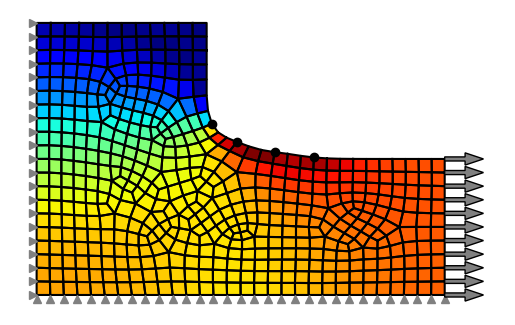

In [15]:
u, f = fillet.solve()
stress = mises_stress(u)

fillet.plot(element_property=stress, cmap="jet")
plt.scatter(
    fillet.nodes[control_nodes, 0].detach(),
    fillet.nodes[control_nodes, 1].detach(),
    marker="o",
    color="black",
)

g) What is the new maximum stress? Discuss the effect of the improvement.

In [16]:
print(max(mises_stress(u)))

tensor(0.6046, grad_fn=<UnbindBackward0>)
